In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import label_binarize

In [2]:
balances = pd.read_table('models_T1/balances.tsv', index_col=0).T
metadata = pd.read_table('CI_merged.txt', index_col=0)
balances = balances.join(metadata[['Location', 'Treatment']], how='left')
#balances.to_csv('balance_mod.csv')
balances.head()

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y2827,y2828,y2829,y2830,y2831,y2832,y2833,y2834,Location,Treatment
Duda.T1.yellow.6.3,-8.814887,-6.822790,-17.845320,2.253715,2.907280e+00,-4.603094,3.055031,-3.237509,6.538291e-16,1.210851e+00,...,-4.685804e-16,2.556418e-18,-5.773522e-19,-5.773522e-19,-8.395639e-18,-5.773522e-19,-5.773522e-19,-5.773522e-19,Duda,Fulvic.Acid.Molasses
Duda.T1.blue.1.1,-1.481545,-2.528142,-0.823112,0.202075,-1.028546e-17,-0.793514,-0.391273,-4.103697,2.474855e-16,-4.309738e-16,...,-1.646360e-16,3.296905e-18,-6.256922e-18,-6.256922e-18,-4.069886e-18,-6.256922e-18,-6.256922e-18,-6.256922e-18,Duda,Fulvic.Acid
Duda.T1.blue.1.2,-9.666972,-8.553466,-15.986840,1.771246,2.657710e+00,-0.138190,11.000096,-1.574198,6.738008e-16,1.640872e-01,...,-1.434662e+00,-5.591521e-18,-1.029925e-17,-2.034219e-01,2.188549e-17,-1.029925e-17,-1.029925e-17,-1.029925e-17,Duda,Fulvic.Acid
Duda.T1.blue.1.3,-14.280222,-6.556745,-20.504111,-0.157491,4.323561e+00,1.437096,6.710097,-3.922278,-2.676921e+00,-1.262082e+00,...,-1.123472e+00,2.589033e-18,1.852734e-18,1.375966e+00,-9.888250e-18,1.852734e-18,1.852734e-18,1.852734e-18,Duda,Fulvic.Acid
Duda.T1.blue.2.1,-6.271575,-6.680694,-10.576450,4.344368,1.442271e+00,-7.881008,4.129193,-4.290295,6.969018e-16,-1.275256e+00,...,-4.173902e-16,-9.807429e-19,2.619250e-18,2.619250e-18,1.956248e-17,2.619250e-18,2.619250e-18,2.619250e-18,Duda,Fulvic.Acid


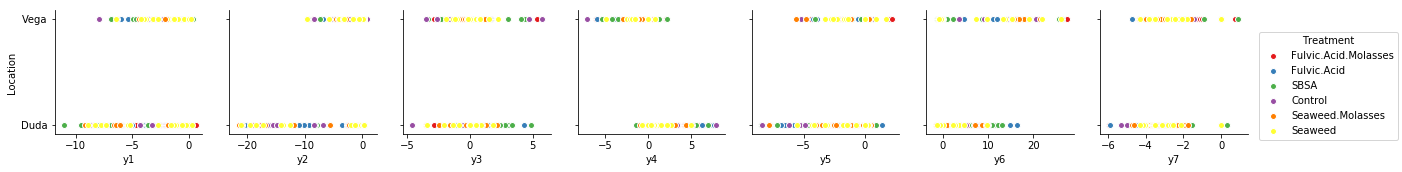

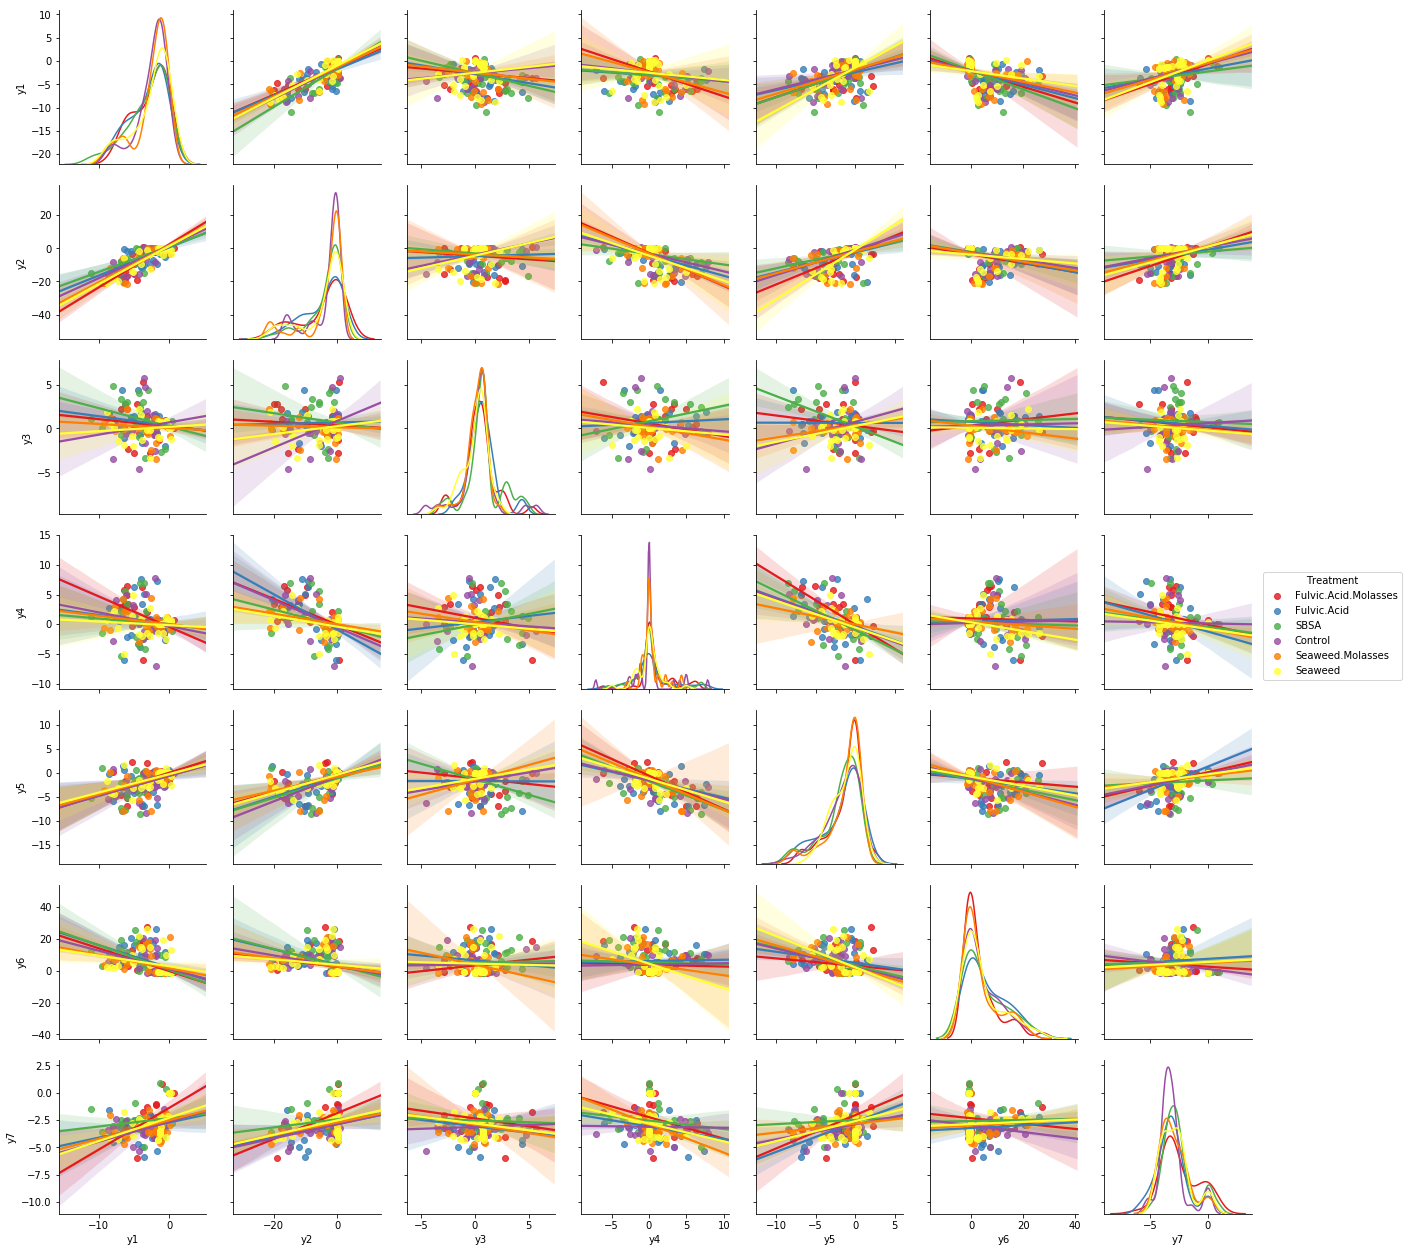

In [49]:
sns.pairplot(balances.iloc[:,[1,2,3,4,5,6,7,-2, -1]], 
             y_vars='Location', 
             x_vars=balances.iloc[:,[1,2,3,4,5,6,7]].columns,
             hue='Treatment',palette='Set1')
sns.pairplot(balances.iloc[:,[1,2,3,4,5,6,7,-2, -1]], 
             hue='Treatment',palette='Set1', kind='reg', diag_kind='kde')

In [14]:
X = balances.drop(['Location', 'Treatment'],axis=1)
y = pd.factorize(balances['Treatment'])[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [16]:
pre = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,
                             n_estimators=50, min_samples_leaf=10, random_state = 42)
pre.fit(X_train, y_train)
pre_pred = pre.predict(X_test)

In [26]:
reversefactor = dict(zip(range(6),pd.factorize(balances['Treatment'])[1]))
index = np.vectorize(reversefactor.get)(y_test)
columns = np.vectorize(reversefactor.get)(pre_pred)
pd.crosstab(index, columns, rownames=['Actual Treatment'], colnames=['Predicted Treatment'])

Predicted Treatment,Control,Fulvic.Acid,Fulvic.Acid.Molasses,SBSA,Seaweed,Seaweed.Molasses
Actual Treatment,,,,,,
Control,3,1,2,3,0,3
Fulvic.Acid,2,0,3,4,1,2
Fulvic.Acid.Molasses,1,2,2,4,0,0
SBSA,1,2,2,2,1,2
Seaweed,1,0,3,7,0,1
Seaweed.Molasses,0,1,3,3,2,1


In [54]:
param_grid = { 
    'n_estimators': [20, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=pre, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
rfc = RandomForestClassifier(n_jobs=-1,max_features= CV_rfc.best_params_['max_features'] ,
                             n_estimators=CV_rfc.best_params_['n_estimators'], min_samples_leaf=10, random_state=42)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

In [55]:
columns = np.vectorize(reversefactor.get)(rfc_pred)
print("parameters used", CV_rfc.best_params_)
print("Classification Report:", "\n", classification_report(index,columns))
print("Confusion matrix:", "\n",pd.crosstab(index, columns, 
                                            rownames=['Actual Treatment'], 
                                            colnames=['Predicted Treatment']))

parameters used {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 20}
Classification Report: 
                       precision    recall  f1-score   support

             Control       0.43      0.25      0.32        12
         Fulvic.Acid       0.10      0.08      0.09        12
Fulvic.Acid.Molasses       0.20      0.33      0.25         9
                SBSA       0.18      0.30      0.22        10
             Seaweed       0.00      0.00      0.00        12
    Seaweed.Molasses       0.00      0.00      0.00        10

         avg / total       0.15      0.15      0.14        65

Confusion matrix: 
 Predicted Treatment   Control  Fulvic.Acid  Fulvic.Acid.Molasses  SBSA  \
Actual Treatment                                                         
Control                     3            2                     3     1   
Fulvic.Acid                 0            1                     1     5   
Fulvic.Acid.Molasses        0            2                 

Text(0.5,0,'Relative Importance')

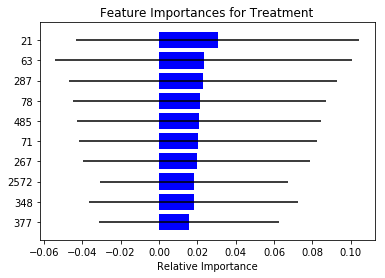

In [57]:
importances = rfc.feature_importances_
indices = np.argsort(importances)
features = balances.columns[-2]
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)

plt.figure(1)
plt.title('Feature Importances for Treatment')
plt.barh(range(len(indices[-10:])), importances[indices[-10:]], color='b', align='center', xerr=std[indices[-10:]])
plt.yticks(range(len(indices[-10:])), indices[-10:])
plt.xlabel('Relative Importance')

/Users/planetx/Applications/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/Users/planetx/Applications/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


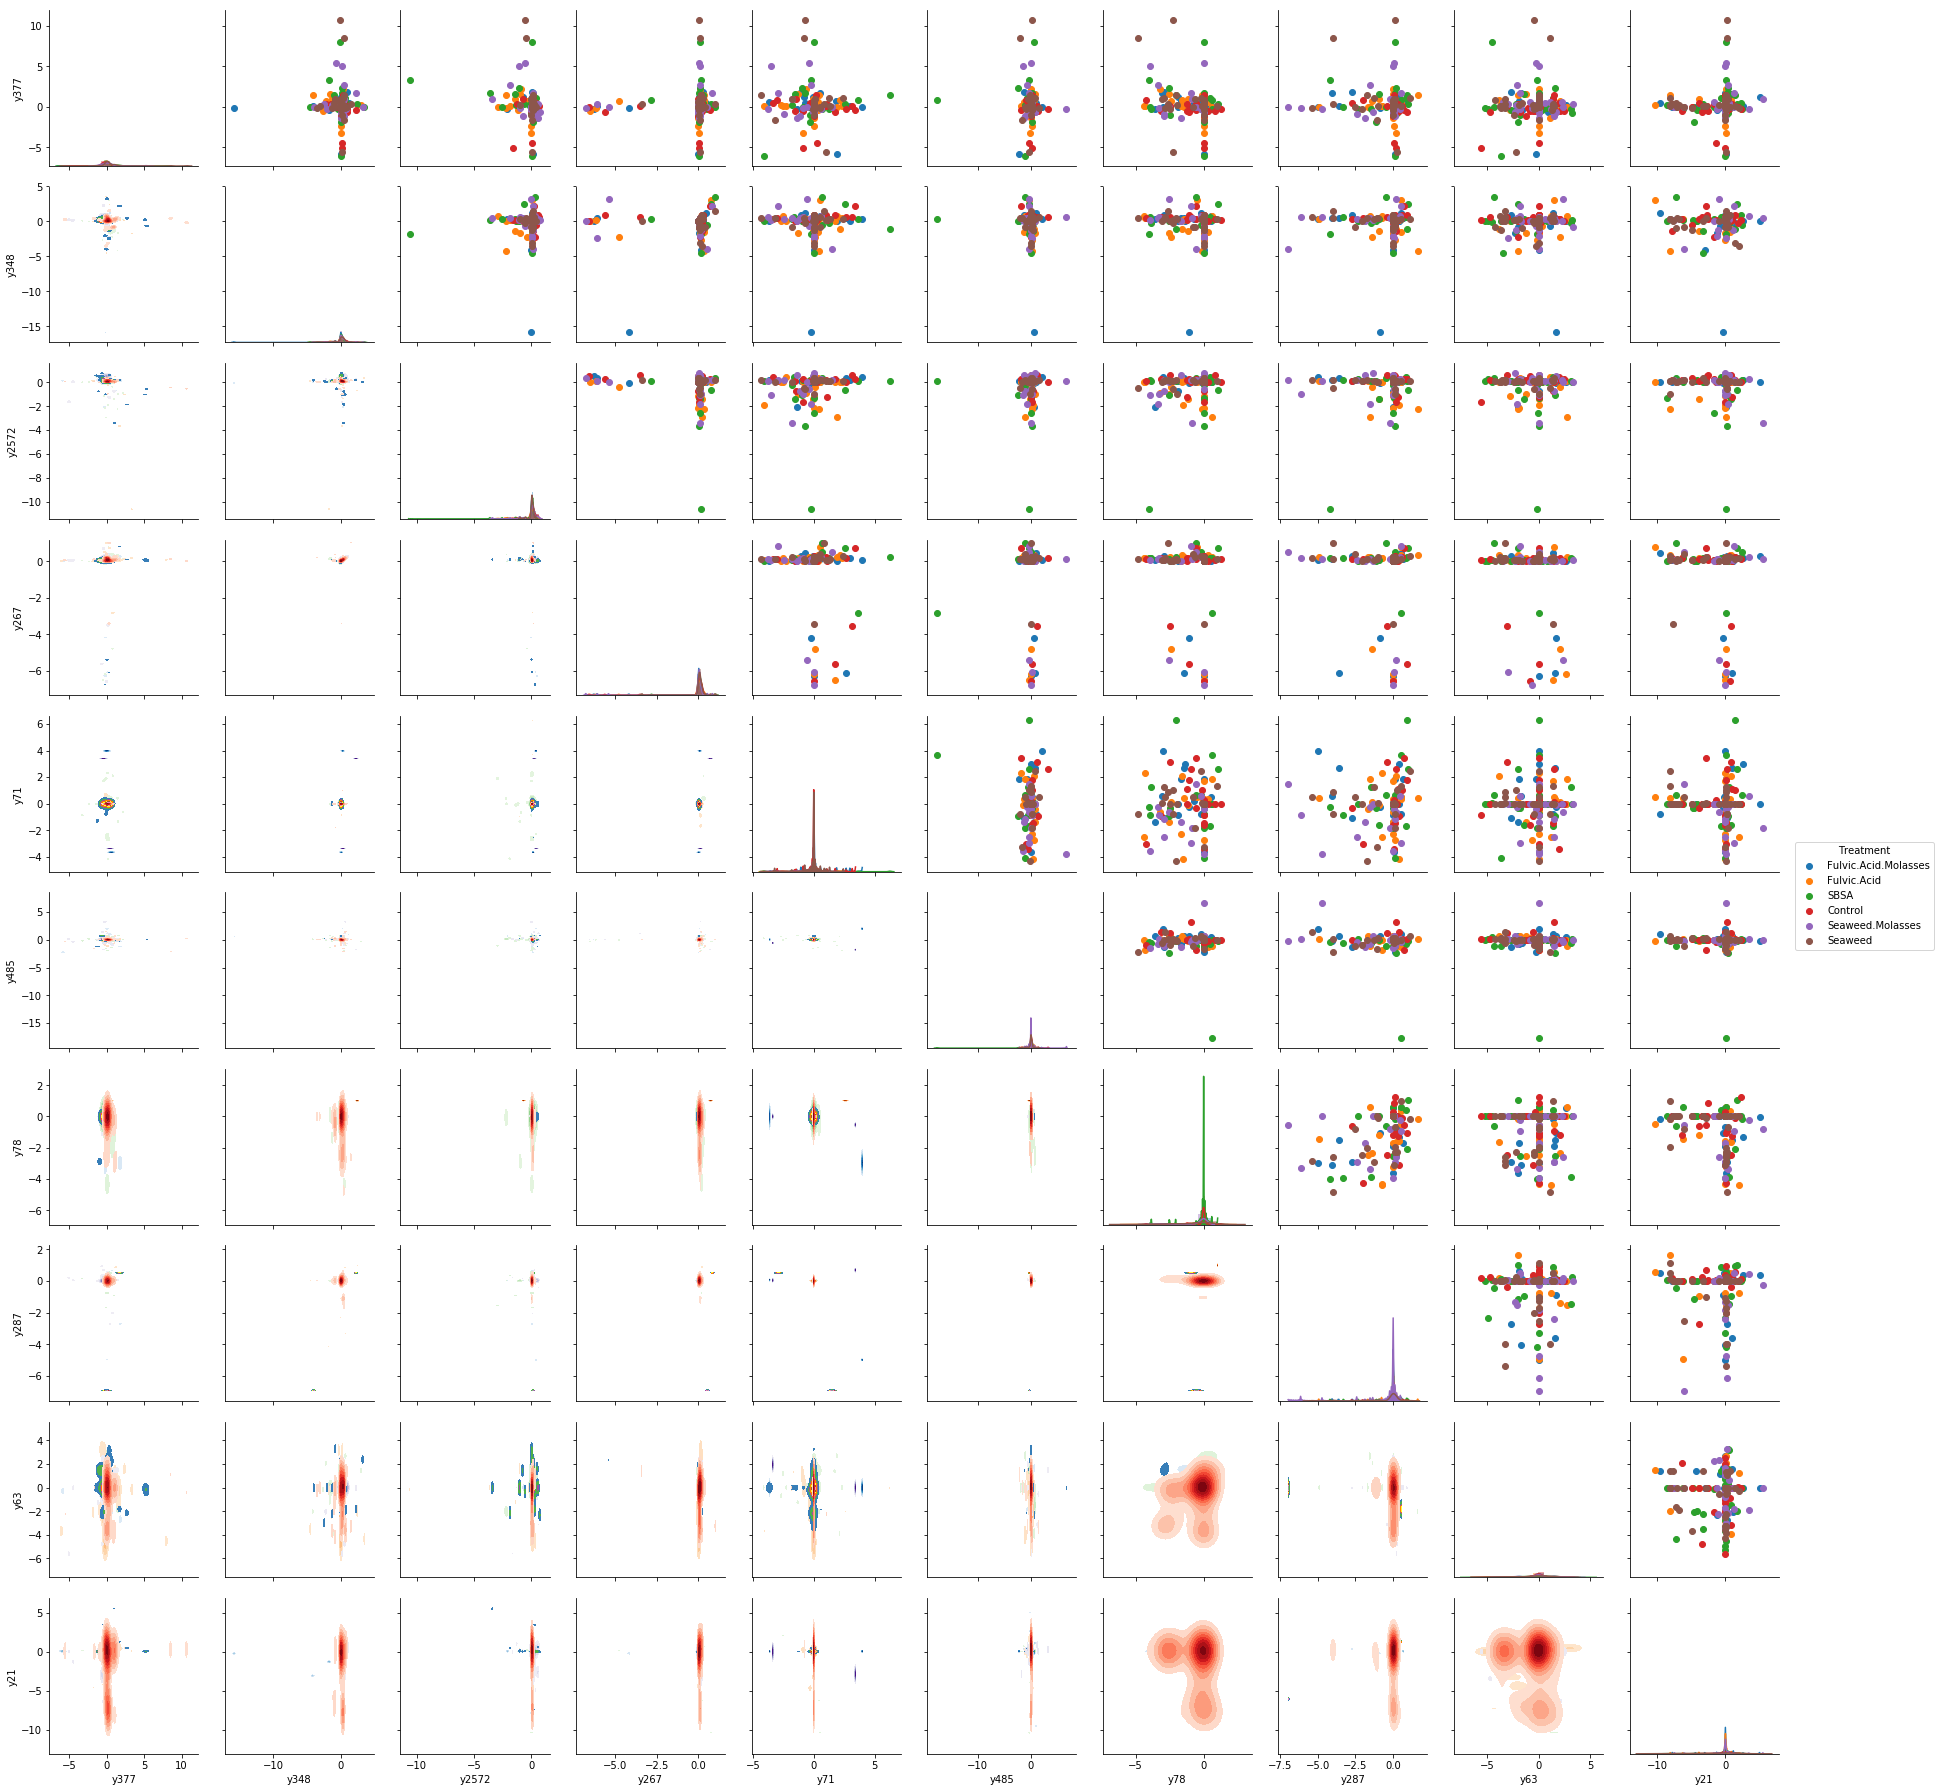

In [150]:
list_of_cmaps=['Blues', 'Greens', 'Oranges', 'Purples', 'Set1', 'Reds']
lst = list(indices[-10:])
lst.append(-2)
lst.append(-1)
lst
g=sns.PairGrid(balances.iloc[:,lst], 
             hue='Treatment',hue_kws={"cmap":list_of_cmaps})
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot, shade=True, shade_lowest=False)
g.map_diag(sns.distplot)
g.add_legend()

In [63]:
from scipy.stats import chi2_contingency
for i in indices[-10:]:
    csq=chi2_contingency(pd.crosstab(balances['y{}'.format(i)], balances['Treatment']))
    print("P-value for y{}".format(i),csq[1])

P-value for y377 0.467850185173
P-value for y348 0.426365829461
P-value for y2572 0.451490155559
P-value for y267 0.443361451518
P-value for y71 0.418277766811
P-value for y485 0.476771114512
P-value for y78 0.384201701712
P-value for y287 0.345443778868
P-value for y63 0.484430632456
P-value for y21 0.424956185815


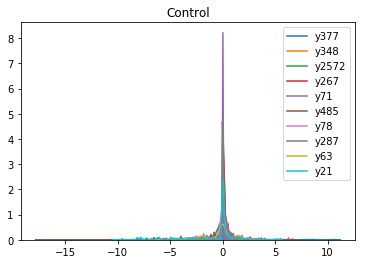

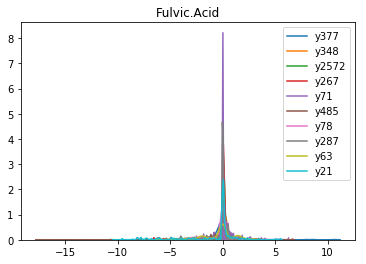

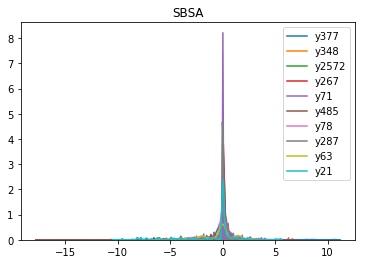

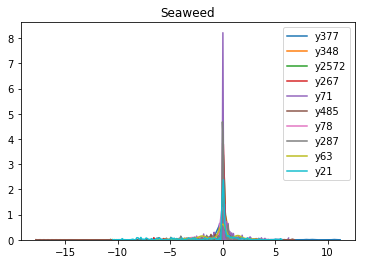

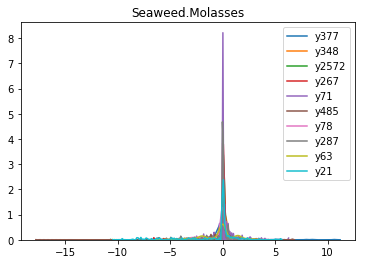

In [111]:
for i in indices[-10:]:
    plt.figure(1)
    sns.kdeplot(balances[['y{}'.format(i), 'Treatment'][['Treatment']=='Control']])
    plt.title('Control')
    
    plt.figure(2)
    sns.kdeplot(balances[['y{}'.format(i), 'Treatment'][['Treatment']=='Fulvic.Acid']])
    plt.title('Fulvic.Acid')
    
    plt.figure(3)
    sns.kdeplot(balances[['y{}'.format(i), 'Treatment'][['Treatment']=='SBSA']])
    plt.title('SBSA')
    
    plt.figure(4)
    sns.kdeplot(balances[['y{}'.format(i), 'Treatment'][['Treatment']=='Seaweed']])
    plt.title('Seaweed')
    
    plt.figure(5)
    sns.kdeplot(balances[['y{}'.format(i), 'Treatment'][['Treatment']=='Seaweed.Molasses']])
    plt.title('Seaweed.Molasses')